In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets  # interactive display
from IPython.display import display
from matplotlib import font_manager as fm
from pathlib import Path

# !wget https://github.com/matomo-org/travis-scripts/blob/master/fonts/Arial.ttf

# font_files = fm.findSystemFonts()
# print(font_files)
# # Go through and add each to Matplotlib's font cache.
# for font_file in font_files:
#     fm.fontManager.addfont(font_file)

# fm.fontManager.ttflist += fm.createFontList(['Arial.ttf'])


# plt.rcParams["font.family"] = "sans-serif"
# plt.rcParams["font.sans-serif"] = ["Arial"]

This notebook simulates responses of a tuned normalization model to varied inputs over time. We first start by setting up a simulation of a proven, published model (Zhou et al, 2019), and then add feature tuning to investigate the effects of shared or separate normalization pools for differentially feature-tuned units.

## Zhou 2019 simulations
First, we simulate the Zhou 2019 delayed normalization model. Next, we will use this model with varied feature-tuning properties to investigate potential effects of 'surprise'.

In [2]:
## inputs
durations = [0, 17, 33, 67, 134, 267, 533]
fixed_duration = 134
total_duration = 1200  # in ms
var_duration = np.vstack(
    [
        np.hstack((np.ones(duration), np.zeros(total_duration - duration)))
        for duration in durations
    ]
)
var_isi = np.vstack(
    [
        np.hstack(
            (
                np.ones(fixed_duration),
                np.zeros(duration),
                np.ones(fixed_duration),
                np.zeros(total_duration - duration - 2 * fixed_duration),
            )
        )
        for duration in durations
    ]
)

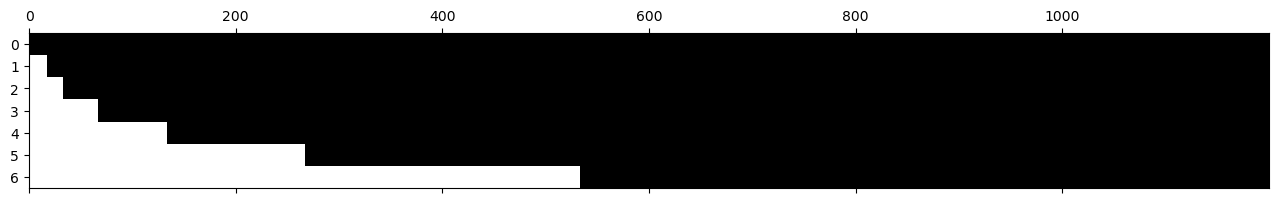

In [3]:
plt.matshow(var_duration, aspect="auto", cmap="gray", interpolation="nearest")
plt.show()

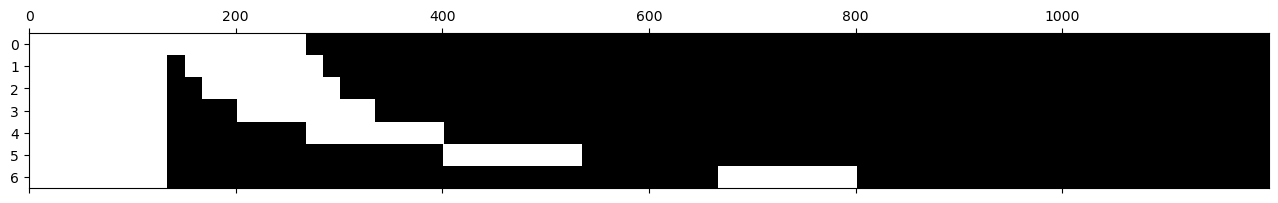

In [4]:
plt.matshow(var_isi, aspect="auto", cmap="gray", interpolation="nearest")
plt.show()

In [5]:
# cleaned up
def compute_irf(t, tau, omega=0.0, transient_factor=1.5):
    """
    computes neuronal impulse response function with "Gamma shape"
    according to Zhou et al 2018 and 2019. The function implements
    the scheme proposed by Zhou et al. 2019, where the IRF is defined
    as a difference between a primary and secondary transient response.

    Setting omega to 0 recovers the scheme from Zhou et al. 2018

    parameters
    t: np.array
        time array
    tau: float
        time constant of the neural response
    omega: float
        weight of secondary, transient response
    transient_factor: float
        how much the secondary transient response is delayed compared
        to the initial response

    outputs
    irf: np.array
        resulting neural response
    """

    # compute initial response
    gamma_1 = t * np.exp(-t / tau)
    # normalize
    gamma_1 /= np.sum(gamma_1)

    # compute transient response
    gamma_2 = t * np.exp(-t / (transient_factor * tau))
    # normalize
    gamma_2 /= np.sum(gamma_2)

    # sum
    irf = gamma_1 - omega * gamma_2
    #     irf /= np.sum(irf)

    return irf


def compute_lin_response(t_inp, tau, dt=1.0, omega=0.0, g=1):
    """
    computes the linear response (R_lin) to a stimulus for a neuronal
    impulse response function (IRF) given parameters tau and omega,
    according to Zhou et al. 2019.

    Setting omega to 0 recovers the scheme from Zhou et al. 2018 as
    the transient part of the IRF will not be considered.

    parameters:
    t_inp : np.array
        stimulus time course
    tau: float
        time constant of the neural response
    dt: float
        time step of t_inp in ms
    omega: float
        weight of secondary, transient response

    outputs:
    linear_response: np.array
        the computed linear response
    """
    t_irf = np.arange(0, 5000 + dt, dt)
    linear_response = np.convolve(t_inp, compute_irf(t_irf, tau, omega))[: len(t_inp)]

    return g * linear_response


def comp_temp_sum(t_inp, tau, sigma, n=2, dt=1.0, omega=0.0, g=1.0):
    """
    Implements the compressive temporal summation model from Zhou et al 2018

    parameters:
    t_inp : np.array
        stimulus time course
    tau: float
        time constant of the neural response
    dt: float
        time step of t_inp in ms
    omega: float
        weight of secondary, transient response
    g: float
        scale or gain factor

    outputs:
    cts: np.array
        the computed compressive temporal summation response
    """
    cts = (
        g
        * (compute_lin_response(t_inp, tau, dt, omega)) ** 2
        / (sigma**2 + (compute_lin_response(t_inp, tau, dt, omega)) ** 2)
    )

    return cts


def delayed_normalization(t_inp, tau_1, tau_2, n, sigma, t, dt=1.0, omega=0.0, g=1):
    """
    Implements the delayed normalization model from Zhou et al 2019
    $$
    R_{DN} = \frac{R_{LN}}{\sigma^n + (|R_{LN}| * h_2(\tau_2))^n}
    $$

    parameters:
    t_inp : np.array
        stimulus time course
    tau_1: float
        time constant of the neural response
    tau_2: float
        time constant of the neural response for normalization pool
    n: float
        exponent of sigma and the normalization pool
    sigma: float
        semisaturation constant
    dt: float
        time step of t_inp in ms
    omega: float
        weight of secondary, transient response
    g: float
        scale or gain factor

    TODO
    - implement shift
    """

    linear_response = compute_lin_response(t_inp, tau_1, dt, omega)

    numerator = np.abs(linear_response) ** n

    denominator = (
        sigma**n
        + np.convolve(np.abs(linear_response), np.exp(-t / tau_2))[
            : len(linear_response)
        ]
        ** n
    )

    norm_response = g * (numerator / denominator)

    return norm_response

<>:106: SyntaxWarning: invalid escape sequence '\s'
<>:106: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_70094/3875684591.py:106: SyntaxWarning: invalid escape sequence '\s'
  R_{DN} = \frac{R_{LN}}{\sigma^n + (|R_{LN}| * h_2(\tau_2))^n}


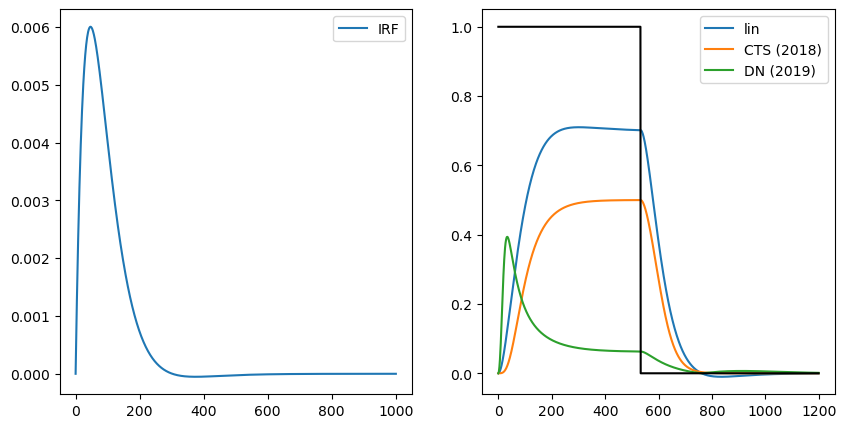

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

## test params
t_irf = np.linspace(
    0, 1000, 1000
)  # changing the amount of points here has the same effect as changing tau, keeping the same resolution btw t_irf and T_input is thus very important
dt = 1
t_irf = np.arange(0, 1000 + dt, dt)
tau = 50
tau_1 = 50
tau_2 = 100
n = 1.1
sigma = 1
omega = 0.3
t = np.linspace(0, 2000, 2000)

axes[0].plot(t_irf, compute_irf(t_irf, tau, omega=0.3), label="IRF")
axes[1].plot(compute_lin_response(var_duration[6], tau, dt, omega=omega), label="lin")
axes[1].plot(
    comp_temp_sum(var_duration[6], tau, sigma, dt=dt, omega=0, g=1), label="CTS (2018)"
)
axes[1].plot(
    delayed_normalization(var_duration[6], tau_1, tau_2, n, sigma, t, dt, omega, g=10),
    label="DN (2019)",
)

axes[1].plot(var_duration[6], color="black")

for ax in axes:
    ax.legend()

# def R_lin(t, tau, g, T_inp, version='2018', omega = 1):

In [7]:
def plot_predictions(
    tau_lin,
    tau_cts,
    tau_1_dn,
    tau_2_dn,
    omega,
    sigma_cts,
    sigma_dn,
    n_dn,
    g_lin,
    g_cts,
    g_dn,
    inputs=var_duration,
    include=["lin", "cts", "dn"],
):

    durations = [0, 17, 33, 67, 134, 267, 533]

    fig, axs = plt.subplots(ncols=2, nrows=7, figsize=(12, 6))
    gs = axs[0, 1].get_gridspec()
    # remove the underlying axes
    for ax in axs[:, -1]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, -1])

    pred_bold_amplitudes = np.zeros((len(inputs), 3))

    for i, ax in enumerate(axs[:, 0]):
        lin_resp = compute_lin_response(inputs[i], tau_lin, dt=1, omega=omega, g=g_lin)
        cts_resp = comp_temp_sum(inputs[i], tau_cts, sigma_cts, dt=dt, omega=0, g=g_cts)
        dn_resp = delayed_normalization(
            inputs[i], tau_1_dn, tau_2_dn, n_dn, sigma_dn, t, dt, omega, g=g_dn
        )

        pred_bold_amplitudes[i] = np.sum(lin_resp), np.sum(cts_resp), np.sum(dn_resp)

        if "lin" in include:
            ax.plot(lin_resp, label="lin")
        if "cts" in include:
            ax.plot(cts_resp, label="CTS")
        if "dn" in include:
            ax.plot(dn_resp, label="DN")

        ax.plot(inputs[i], color="black")

    axbig.plot(durations, pred_bold_amplitudes)
    axbig.legend(["lin", "CTS", "DN"])


#     axbig.set_ylim(0, 600)

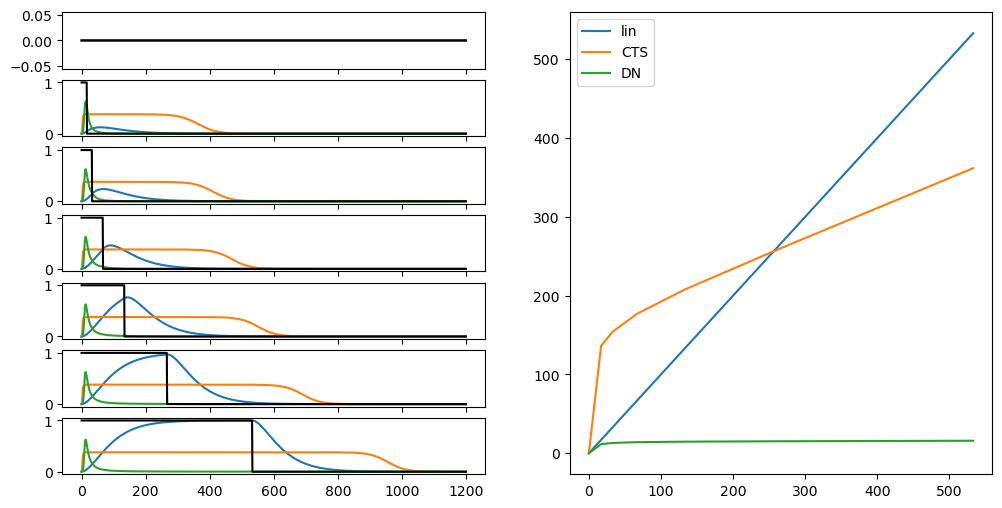

In [8]:
plot_predictions(
    tau_lin=50,
    tau_cts=50,
    tau_1_dn=50,
    tau_2_dn=100,
    omega=0,
    sigma_cts=0.002,
    sigma_dn=0.1,
    n_dn=2,
    g_lin=1,
    g_cts=0.38,
    g_dn=22.7,
    inputs=var_duration,
)

In [9]:
var_isi, var_duration

(array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], shape=(7, 1200)),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], shape=(7, 1200)))

In [10]:
# Define interactive widget controls
tau_lin_slider = widgets.FloatSlider(
    value=50, min=1.0, max=1000.0, step=5.0, description="tau_lin (ms):"
)
tau_cts_slider = widgets.FloatSlider(
    value=50, min=1.0, max=1000.0, step=5.0, description="tau_cts (ms):"
)
tau_1_dn_slider = widgets.FloatSlider(
    value=50, min=1.0, max=1000.0, step=5.0, description="tau_1_dn (ms):"
)
tau_2_dn_slider = widgets.FloatSlider(
    value=100, min=1.0, max=1000.0, step=5.0, description="tau_2_dn (ms):"
)
omega_slider = widgets.FloatSlider(
    value=0.0, min=0.0, max=1.0, step=0.01, description="omega:"
)
sigma_cts_slider = widgets.FloatSlider(
    value=0.1, min=0.001, max=1.0, step=0.001, description="sigma_cts:"
)
sigma_dn_slider = widgets.FloatSlider(
    value=0.1, min=0.0, max=1.0, step=0.01, description="sigma_dn:"
)
n_dn_slider = widgets.FloatSlider(
    value=2.0, min=0.0, max=6.0, step=0.1, description="n_dn:"
)
g_lin_slider = widgets.FloatSlider(
    value=1.0, min=0.0, max=10.0, step=0.1, description="g_lin:"
)
g_cts_slider = widgets.FloatSlider(
    value=1, min=0.0, max=10.0, step=0.01, description="g_cts:"
)
g_dn_slider = widgets.FloatSlider(
    value=5, min=0.0, max=100.0, step=0.1, description="g_dn:"
)

# selections
plot_lin = widgets.Dropdown(options=[True, False], value=True, description="plot_lin:")
plot_cts = widgets.Dropdown(options=[True, False], value=True, description="plot_cts:")
plot_dn = widgets.Dropdown(options=[True, False], value=True, description="plot_dn:")
plot_stim = widgets.Dropdown(
    options=[True, False], value=True, description="plot_stim:"
)
# which_stim = widgets.Dropdown(options=[("Duration", var_duration), ("ISI", var_isi)], value=var_duration, description='Stim:')
# which_stim = widgets.Dropdown(options=[var_duration, var_isi], value=var_duration, description='Stim:')

# Group sliders into columns
column1 = widgets.VBox(
    [tau_lin_slider, g_lin_slider, plot_lin, plot_cts, plot_dn, plot_stim]
)  # linear params
column2 = widgets.VBox([tau_cts_slider, sigma_cts_slider, g_cts_slider])  # cts params
column3 = widgets.VBox(
    [
        tau_1_dn_slider,
        tau_2_dn_slider,
        sigma_dn_slider,
        omega_slider,
        n_dn_slider,
        g_dn_slider,
    ]
)  # DN sliders

# Arrange columns horizontally
ui = widgets.HBox([column1, column2, column3])

# Create interactive output
out = widgets.interactive_output(
    plot_predictions,
    {
        "tau_lin": tau_lin_slider,
        "tau_cts": tau_cts_slider,
        "tau_1_dn": tau_1_dn_slider,
        "tau_2_dn": tau_2_dn_slider,
        "omega": omega_slider,
        "sigma_cts": sigma_cts_slider,
        "sigma_dn": sigma_dn_slider,
        "n_dn": n_dn_slider,
        "g_lin": g_lin_slider,
        "g_cts": g_cts_slider,
        "g_dn": g_dn_slider,
    },
)
# ,'inputs': which_stim
# Display widgets and output
display(ui, out)

Output()

## New, feature-tuned delayed normalization across the visual hierarchy.

Let's create two normalization pools, one tuned to horizontal bar presentations, and the other to vertical bars. An extra parameter governs whether there is any cross-normalization between the pools.

Then we can fill in relevant parameters that allow us to simulate responses of putative low-level and high-level visual areas.

First, we set up an all-purpose function that does the actual simulations, using some of the code already defined for the Zhou model above.

In [11]:
def delayed_normalization_featuretuned(
    t_inp_1,
    t_inp_2,
    tau_1,
    tau_2,
    n,
    sigma,
    t,
    dt=1.0,
    omega=0.0,
    g=1,
    share_ratio=0,
    spatial_to_temporal_underestimation=1,
):
    """
    Implements the delayed normalization model from Zhou et al 2019 but now with
    two populations that have differential feature tuning and share more or less
    of their normalization pools.

    parameters:
    t_inp_1 : np.array
        stimulus time course of the 'expected' stimulus
    t_inp_2 : np.array
        stimulus time course of the 'unexpected' stimulus
    tau_1: float
        time constant of the neural response
    tau_2: float
        time constant of the neural response for normalization pool
    n: float
        exponent of sigma and the normalization pool
    sigma: float
        semisaturation constant
    dt: float
        time step of t_inp in ms
    omega: float
        weight of secondary, transient response
    g: float
        scale or gain factor
    share_ratio: float
        share ratio between the two pools
    spatial_to_temporal_underestimation: float
        how much we're underestimating the expected stimulus' response
        due to temporal normalization in the spatial pRF mapping paradigm.
        lower values indicate more underestimation.
        Default: 1 - balanced, no underestimation.
    TODO
    - implement shift
    """

    linear_response_1 = compute_lin_response(t_inp_1, tau_1, dt, omega)
    linear_response_2 = compute_lin_response(t_inp_2, tau_1, dt, omega)

    numerator_1 = np.abs(linear_response_1) ** n
    numerator_2 = np.abs(linear_response_2) ** n

    denominator_1 = (
        sigma**n
        + np.convolve(np.abs(linear_response_1), np.exp(-t / tau_2))[
            : len(linear_response_1)
        ]
        ** 2
    )
    denominator_2 = (
        sigma**n
        + np.convolve(np.abs(linear_response_2), np.exp(-t / tau_2))[
            : len(linear_response_2)
        ]
        ** 2
    )

    norm_response_1 = g * (
        numerator_1 / ((1 - share_ratio) * denominator_1 + share_ratio * denominator_2)
    )
    norm_response_2 = g * (
        numerator_2 / ((1 - share_ratio) * denominator_2 + share_ratio * denominator_1)
    )

    return (
        norm_response_1 / spatial_to_temporal_underestimation,
        norm_response_2,
    )  # we are not going to use spatial_to_temporal_underestimation

Then, we have to set up a simulation protocol that mimics our pRF experiment, with its violations in there. We also set all the relevant parameters to their parameters from Zhou et al.

In [12]:
# we'll simulate everything in milliseconds, for one bar pass
times = np.linspace(0, 32000, 32000)

vertical_input_times = np.r_[
    np.tile(np.r_[np.zeros(800), np.ones(800)], 9),
    np.zeros(1600),
    np.tile(np.r_[np.zeros(800), np.ones(800)], 10),
]
horizontal_input_times = np.r_[
    np.zeros(1600 * 9), np.r_[np.zeros(800), np.ones(800)], np.zeros(1600 * 10)
]

# basic parameters
tau_1_dn = 50
tau_2_dn_V1 = 110
tau_2_dn_ant = 150
omega = 0.2
sigma_cts = 0.002
sigma_dn = 0.03
n_dn = 1.1
g_lin = 1
g_cts = 0.38
g_dn = 22.7
# new parameters, to be played with in simulations
spatial_to_temporal_underestimation = 1  # no systematic underestimation
share_ratio_V1 = 0.99  # fully shared normalization pools
share_ratio_ant = 0.60  # fully separate normalization pools
# and our modelling shares these primary responses,
# it's all in the combination across time and feature-tuning that we vary things.
lin_resp_vert = compute_lin_response(
    vertical_input_times, tau_1_dn, dt=1, omega=omega, g=g_lin
)
lin_resp_hor = compute_lin_response(
    horizontal_input_times, tau_1_dn, dt=1, omega=omega, g=g_lin
)

# the timepoints to focus on
vert_time_slice = slice((8 * 1600) + 600, (8 * 1600) + 2000)
hor_time_slice = slice((9 * 1600) + 600, (9 * 1600) + 2000)

In [13]:
# This option simulates a anterior-level visual cortex responses, parameter from V3a in Groen et al, 2022
dn_resp_vert, dn_resp_hor = delayed_normalization_featuretuned(
    vertical_input_times,
    horizontal_input_times,
    tau_1_dn,
    tau_2_dn_ant,
    n_dn,
    sigma_dn,
    t,
    dt,
    omega,
    g=g_dn,
    share_ratio=share_ratio_ant,
    spatial_to_temporal_underestimation=spatial_to_temporal_underestimation,
)

# Now, what happens when the opposite-tuned pool doesn't activate this one,
# but does cause its normalization pool to pre-heat? This is what would happen
# if a V1 voxel's normalization pool has been "pre-heated" by a pRF bar that
# is still outside of its pRF center. This pre-heating is implemented by a
# share_ratio larger than 0.5
dn_resp_vert_v1, dn_resp_hor_v1 = delayed_normalization_featuretuned(
    vertical_input_times,
    horizontal_input_times,
    tau_1_dn,
    tau_2_dn_V1,
    n_dn,
    sigma_dn,
    t,
    dt,
    omega,
    g=g_dn,
    share_ratio=share_ratio_V1,
    spatial_to_temporal_underestimation=spatial_to_temporal_underestimation,
)

# simulation of a progression from one to the other extreme
progression = []  # TRMI
progression_untuned = []  # TRMI untuned
for tau_2, sr in zip(np.linspace(110, 150, 20), np.linspace(0.95, 0.55, 20)):
    v, h = delayed_normalization_featuretuned(
        vertical_input_times,
        horizontal_input_times,
        tau_1_dn,
        tau_2,
        n_dn,
        sigma_dn,
        t,
        dt,
        omega,
        g=g_dn,
        share_ratio=sr,
        spatial_to_temporal_underestimation=spatial_to_temporal_underestimation,
    )
    v_untuned, h_untuned = delayed_normalization_featuretuned(
        vertical_input_times,
        horizontal_input_times,
        tau_1_dn,
        tau_2,
        n_dn,
        sigma_dn,
        t,
        dt,
        omega,
        g=g_dn,
        share_ratio=1,
        spatial_to_temporal_underestimation=spatial_to_temporal_underestimation,
    ) # This is not really a untuned model, just a simulation of an adaption progression
    progression.append(
        np.sum(h[hor_time_slice])
        / (np.sum(v[vert_time_slice]) + np.sum(h[hor_time_slice]))
        - 0.5
    )
    progression_untuned.append(
        np.sum(h_untuned[hor_time_slice])
        / (np.sum(v_untuned[vert_time_slice]) + np.sum(h_untuned[hor_time_slice]))
        - 0.5
    )

In [14]:
def cm_to_inch(*dims):
    return tuple(dim / 2.54 for dim in dims)

In [15]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from matplotlib.colors import LightSource
from scipy.stats import t
from matplotlib import rc
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

cwd = os.getcwd()
font_dirs = [Path(cwd).parent.parent / "arial"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc("pdf", fonttype=42, use14corefonts=False)
rc("axes", linewidth=0.5)
rc("font", **{"family": "Arial"})
rc("text", usetex=False)
rc("xtick", labelsize=6)
rc("ytick", labelsize=6)
rc("axes", labelsize=7)
rc("legend", fontsize=6)

plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.minor.size"] = 1

# set up figure parameters
markeredgecolor = ".4"
bar_linewidth = 0.5
bar_alpha = 0.7
xticks_rotation = 45
marker = "s"
marker_edge_width = 0.5
markersize = 4 / 2.54
errorbar_linewidth = 0.5
errorbar_capsize = 0.7 / 2.54
errorbar_capthick = 0.5

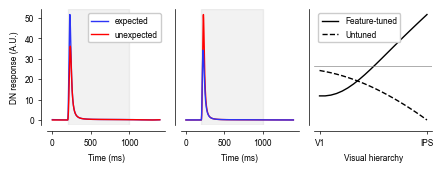

In [16]:
fig, ax = plt.subplots(
    ncols=3, nrows=1, figsize=cm_to_inch(11.4, 4.5)
)  # , gridspec_kw={'height_ratios': [2, 2, 2, 2, 2]}

vert_color = "#2d34f6"
hor_color = "#ff0000"
# ax[0].set_title('low-level DN response: \nfast timescale, \nno stimulus orientation tuning, \nlarge spatial normalization pool')
ax[0].plot(dn_resp_vert_v1[vert_time_slice], label="expected", color=vert_color, lw=1)
ax[0].plot(dn_resp_hor_v1[hor_time_slice], label="unexpected", color=hor_color, lw=1)
ax[0].legend(alignment="right", frameon=True, framealpha=1, loc=1)
ax[0].axvspan(200, 1000, color="gray", alpha=0.1)

# ax[1].set_title('high-level DN response: \nslower timescale, \nstimulus orientation tuning, \n small spatial normalization pool')
ax[1].plot(dn_resp_hor[hor_time_slice], color=hor_color, lw=1)
ax[1].plot(dn_resp_vert[vert_time_slice], color=vert_color, lw=1)
ax[1].axvspan(200, 1000, color="gray", alpha=0.1)
ax[1].axes.get_yaxis().set_visible(False)


# ax[2].set_title('from V1 to IPS-like responses')
ax[2].plot(
    np.arange(len(progression)), progression, color="black", lw=1, label="Feature-tuned"
)
ax[2].plot(
    np.arange(len(progression_untuned)),
    progression_untuned,
    color="black",
    linestyle="--",
    lw=1,
    label="Untuned",
)
ax[2].axhline(0, color="grey", alpha=0.9, lw=0.5)
# ax[2].axes.get_yaxis().set_visible(False)
ax[2].legend(alignment="left", frameon=True, framealpha=1, loc=2)
ax[2].set_xticks(ticks=[0, 19], labels=["V1", "IPS"])
ax[2].set_yticks([])
# ax[2].set_yticks(ticks=[-0.1, 0, 0.1], labels=[-0.1, 0, 0.1])


ax[0].set_xlabel("Time (ms)", fontsize=6)
ax[1].set_xlabel("Time (ms)", fontsize=6)
# ax[2].set_xlabel('Fast, Shared - Slow, Separate')
ax[2].set_xlabel("Visual hierarchy", fontsize=6)
# ax[2].set_ylabel('Temporal response modulation index', fontsize=6)
# ax[2].yaxis.set_label_coords(-0.5, 0.48)

ax[0].set_ylabel("DN response (A.U.)", fontsize=6)
# ax[2].set_ylabel('Total response\nUnexpected / expected')

plt.tight_layout()
sns.despine(offset=4)
# plt.subplots_adjust(wspace=0.3)
# ax[0].axes.get_xaxis().set_visible(False)
# ax[0].axes.get_xaxis().set_visible(False)
# ax[0].axes.get_yaxis().set_visible(False)
# ax[1].axes.get_yaxis().set_visible(False)
path_cwd = Path().absolute()
figure_result_dir = Path(
    path_cwd.joinpath("figures")
)
plt.savefig(
    figure_result_dir.joinpath(f"feature_tuned_normalization_simulation.pdf"),
    bbox_inches="tight",
    dpi=600,
)